In [108]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

In [109]:
nwb_file_name = 'senor20201030_.nwb'

In [110]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'
trial_data = pd.read_csv(filename)
trial_data

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf4,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
#only look at one session 
trial_data_sesh = trial_data[trial_data.epoch==2]

In [112]:
#this will label trials where he is ABOUT to stem switch. the trial before stem switch, stem switch=true. 

trial_data_sesh['stem_switch'] = trial_data_sesh['stem'].ne(trial_data_sesh['stem'].shift())

for ix in range(len(trial_data_sesh)):
    if trial_data_sesh.loc[ix,'trial_number_by_epoch']==0:
        trial_data_sesh.loc[ix,'stem_switch']= True
trial_data_sesh['stem_switch']=trial_data_sesh['stem_switch'].shift(-1)        
trial_data_sesh

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [113]:
# theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])
theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])


position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()

In [114]:
#This will find the length of the session by using the trial times in the data. probably not the best way to do this! how to grab the whole session times?

num_secs_to_get = int(trial_data_sesh.iloc[-1].poke_out_ts - trial_data_sesh.iloc[0].poke_in_ts-1)
num_secs_to_get

1144

In [134]:


electrode_id = [8,17,40,132,244,300]
time_from_start = 0 #in seconds
time_interval_s = num_secs_to_get
sampling_rate_lfp = 1000
epoch = (IntervalList & {'nwb_file_name':nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)
x_elect_lfp, y_elect_lfp = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_theta, y_elect_theta = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)



frequency resolution: 6.0


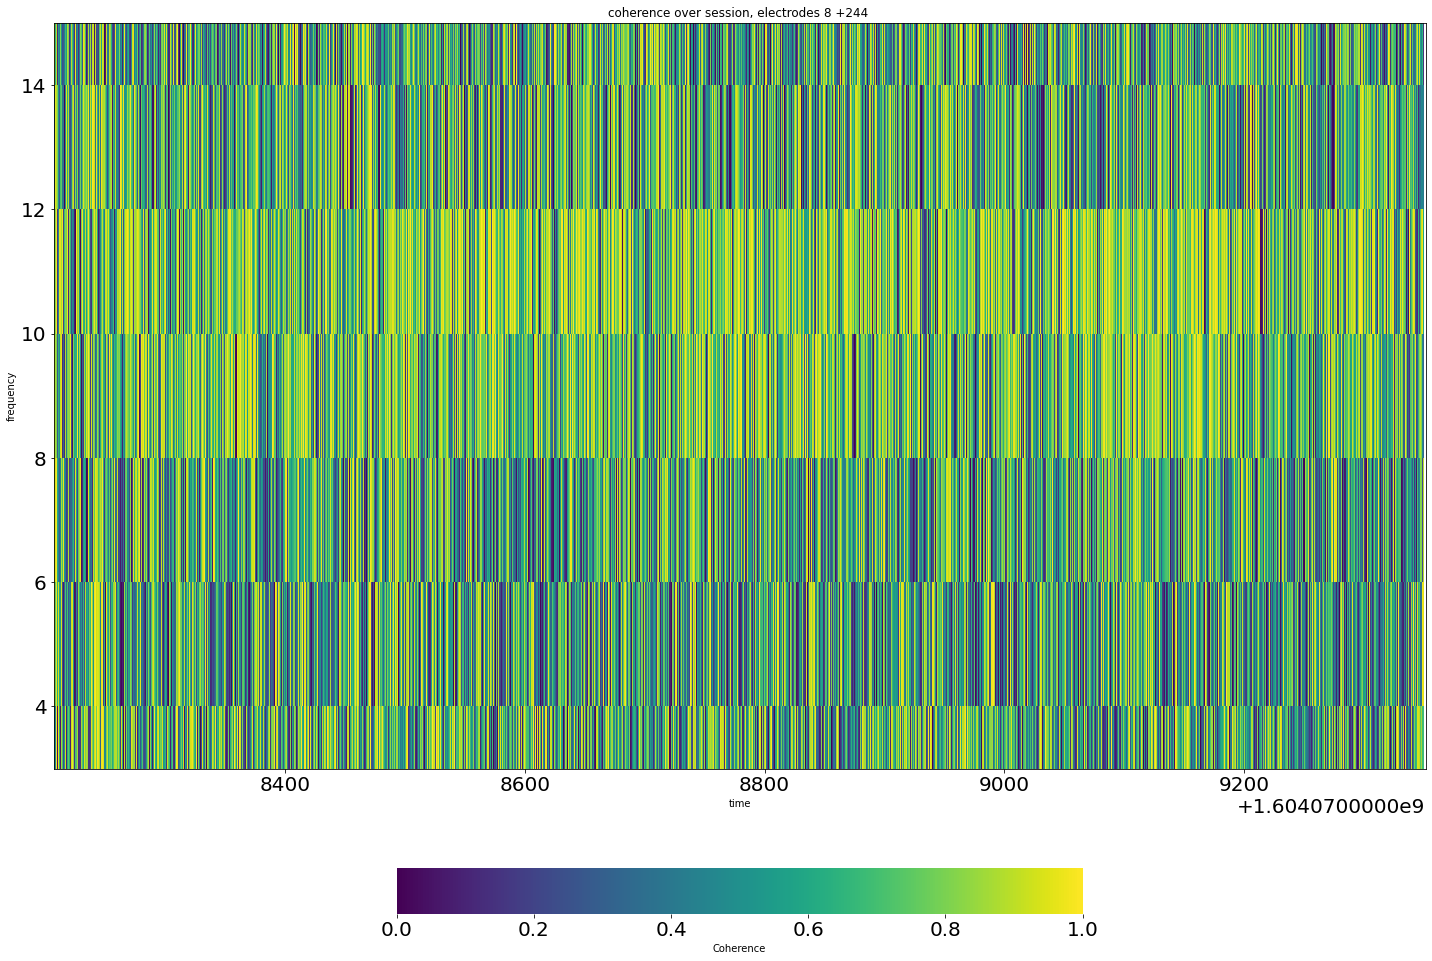

In [135]:
%matplotlib inline
time_halfbandwidth_product = 1.5
sampling_frequency = 1000
time_res=.5


electrode_ix1= 0
electrode_ix2= 4


time_data = x_elect_lfp[electrode_ix1]
signal = np.zeros((len(time_data), 2))
signal[:,0] = y_elect_lfp[electrode_ix1]
signal[:,1]=y_elect_lfp[electrode_ix2]



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=time_res,
               time_window_step=None,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
time_grid, freq_grid = np.meshgrid(
    np.append(c.time, c.time[-1]),
    np.append(c.frequencies, m.nyquist_frequency))

plt.figure(figsize=(20,15))
mesh = plt.pcolormesh(time_grid,freq_grid , c.coherence_magnitude()[..., 0, 1].squeeze().T,
                             vmin=0.0, vmax=1.0, cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.ylim(3,15)
plt.xlim(time_data[0],time_data[-1])
plt.title(f'coherence over session, electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} ')


plt.tight_layout()
cb = plt.colorbar(mesh, orientation='horizontal',
                  shrink=.5, aspect=15, pad=0.1, label='Coherence')
# cb = plt.colorbar(mesh, ax.ravel().tolist(), orientation='horizontal',
#                   shrink=.5, aspect=15, pad=0.1, label='Coherence')
cb.outline.set_linewidth(0)
cb.outline.set_linewidth(0)
print('frequency resolution: {}'.format(m.frequency_resolution))
#maybe about two minutes

In [136]:
freq_seg = c.frequencies[(c.frequencies >= 7.5) & (c.frequencies <=9)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies >= 7.5) & (c.frequencies <=9)]
freq_seg

array([8.])

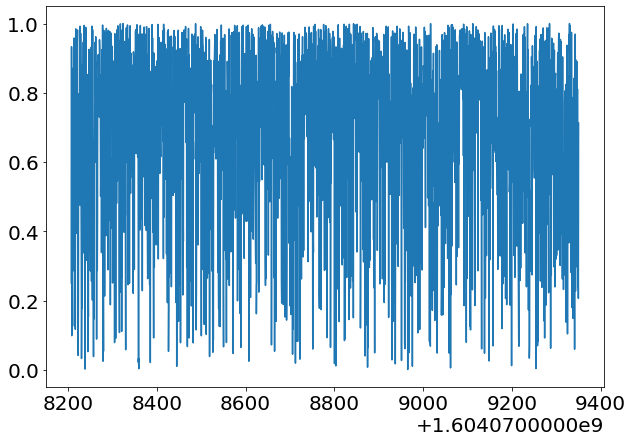

In [137]:
plt.figure(figsize=(10,7))
plt.plot(c.time,coh_seg[0])

In [ ]:
#so now, i want to pick out certain trial times. This is the part that I want to be the most flexible. 
#only the trial times for stay trials. Or only for go. 
#or only stay trials at one stem. 

#then once I have the trail times, I want to pass it in to some masking, alignment, and plot them. 

In [127]:
trial_data_sesh[0:10]
#so if I want only all A, stay trials, I want all A trials where stem switch = false. 
#cant 

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,senor20201030_.nwb,2,6,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,senor20201030_.nwb,2,7,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8,senor20201030_.nwb,2,8,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,senor20201030_.nwb,2,9,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [138]:
trial_times=[]
for ix in range(len(trial_data_sesh)-1):
    if trial_data_sesh.iloc[ix].stem_switch == False:
        # if trial_data_sesh.iloc[ix].trial_number_by_epoch >=60:
        # if trial_data_sesh.iloc[ix].trial_number_by_epoch <60:
            # if trial_data_sesh.iloc[ix].stem == 'C':
        trial_start = trial_data_sesh.iloc[ix].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix+1].poke_in_ts
            # if trial_end-trial_start<3:
        trial_times.append([trial_start, trial_end])

In [129]:
len(trial_times)
#51 stay trials in the first contingency. 
#27 where he stays at A. 
#164 stay trials in whole session, 15 go trials. 

164

Text(0.5, 0, 'time')

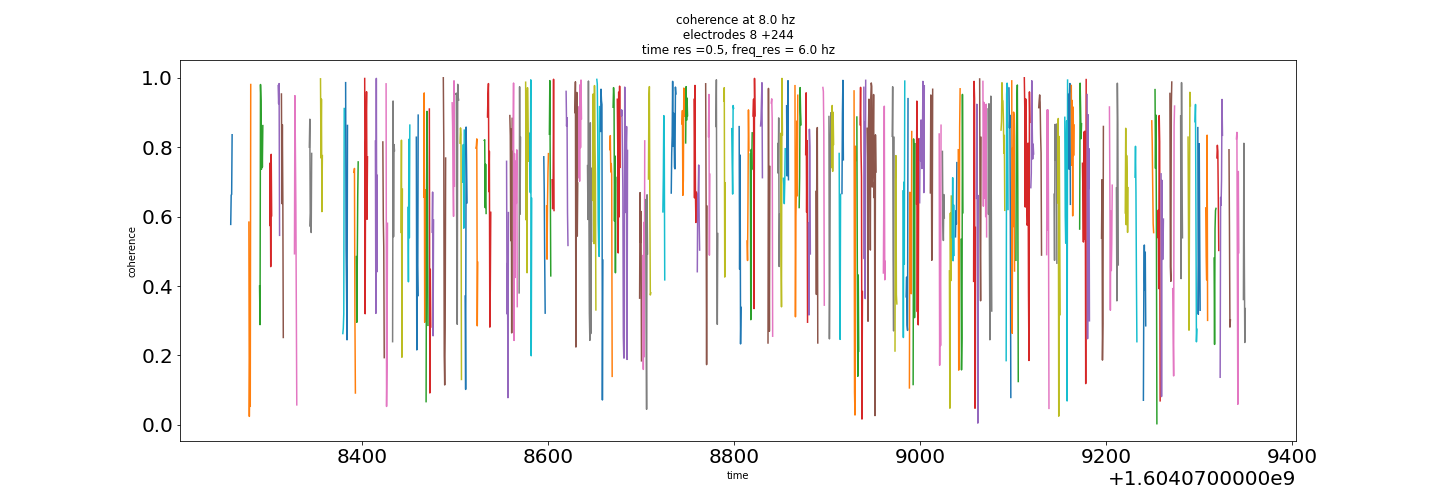

In [139]:
%matplotlib widget
plt.figure(figsize=(20,7))
for times in range(len(trial_times)):
    trial_start=trial_times[times][0]
    trial_end = trial_times[times][1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    plt.plot(masked_time,masked_data)
    # plt.vlines(trial_start,0,1,color='g',label='trial_start',alpha=.6)
    # plt.vlines(trial_end,0,1,color='red',label='trial_end',alpha=.6)
    plt.title(f'coherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz ')

plt.ylabel('coherence')
plt.xlabel('time')
# plt.legend()

# plt.figure(figsize=(15,7))
# for times in range(len(trial_times)):
#     trial_start=trial_times[times][0]
#     trial_end = trial_times[times][1]
#     ind_start = x_pos>=trial_start 
#     ind_end = x_pos<=trial_end
#     masked_time = x_pos[ind_start&ind_end]
#     masked_data = y_pos[ind_start&ind_end]
#     plt.plot(masked_time,masked_data)
#     # plt.vlines(trial_start,0,80,color='g',label='trial_start',alpha=.6)
#     # plt.vlines(trial_end,0,80,color='red',label='trial_end',alpha=.6)
#     # plt.legend()

Text(0.5, 0, 'time bins since start of trial- =second*2')

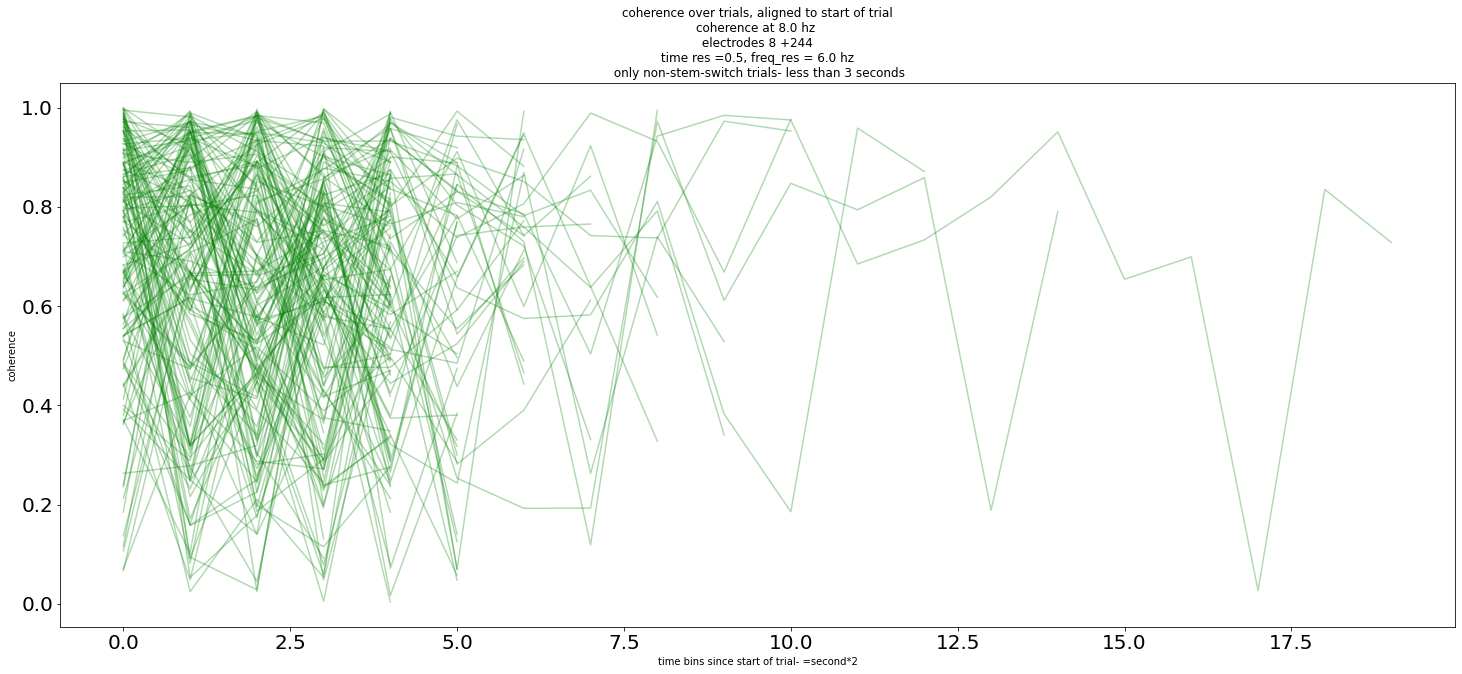

In [140]:
%matplotlib inline
plt.figure(figsize=(25,10))
saved_times = []
saved_data = []
for times in range(len(trial_times)):
    trial_start=trial_times[times][0]
    trial_end = trial_times[times][1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed=[]
#first, mask the data. 
#Then for every time in the masked times data, subtract the first time of that trial so that they all start at zero. 
    for ix in range(len(masked_time)):
        masked_times_zeroed.append(masked_time[ix]- trial_times[times][0])
    saved_times.append(masked_times_zeroed)
    saved_data.append(masked_data)
saved_data_lists=[]
for ix in range(len(saved_data)): 
    saved_data_lists.append(saved_data[ix].tolist())
df = pd.DataFrame(saved_data_lists)

for ix in range(len(df)):
    plt.plot(df.iloc[ix], color='g', alpha=.3)

    # plt.plot(masked_times_zeroed,masked_data, label = f'trial {times+1}')
    # plt.vlines(trial_start,0,1,color='g',label='trial_start',alpha=.6)
    # plt.vlines(trial_end,0,1,color='red',label='trial_end',alpha=.6)
# plt.title(')
plt.title(f'coherence over trials, aligned to start of trial\ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz \n only non-stem-switch trials- less than 3 seconds')


plt.ylabel('coherence')
plt.xlabel('time bins since start of trial- =second*2')
# plt.legend()

In [ ]:
#So my questions: 
#should my next step be to put all on same axis- prop of time - go for this 

#linearized position might be easier to work with. 

#can start working with position data. 

#What i should do first is combine all my notes, figure out the questions that I want to prioritize. talk to AC after each step. 
#Then go back to characterizing these ones a bit.. make something of the averaging plots. 
#interpret it! 
# normalziing time, do the avererging. 
#start working with position stuff after, but in small chunks. 

In [132]:
df

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.727212,0.254940,0.566613,0.646554,0.484911,0.991401,0.812861,0.584441,0.730217,0.934502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.571874,0.578491,0.432515,0.098896,0.107446,0.108163,0.007830,0.836580,0.758200,0.835215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.428273,0.418096,0.776354,0.716294,0.702491,0.725604,0.342081,0.565259,0.702836,0.776295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.779523,0.522012,0.611973,0.832129,0.222089,0.374960,0.437896,0.685962,0.906116,0.912760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.530143,0.999482,0.597155,0.748737,0.833412,0.851675,0.960226,0.884983,0.536778,0.524493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0, 'time bin- .5s bins')

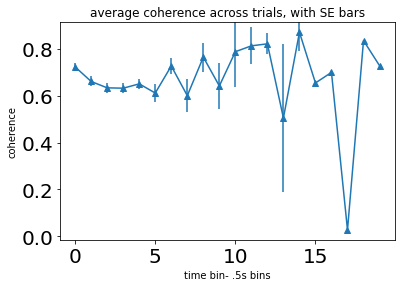

In [141]:
df2 = df.mean(axis=0)
df2

df2_SE = df.sem
# plt.plot(df2)
# plt.title('average of all session 1 coherences on stay trials- now pfc CC')
# plt.title('average of all stay trial coherence values\n note that most trials are only 2 seconds long, meaning 4 data points')

# plt.xlabel('coherence sample number- time res = .3s')
# plt.ylabel('coherence')
df2_SE = df.sem(axis=0,skipna=True)
plt.errorbar(df2.index, df2, df2_SE, marker='^')  
# plt.ylim(0,1)
plt.title('average coherence across trials, with SE bars') 
plt.ylabel('coherence')
plt.xlabel('time bin- .5s bins') 

Text(0.5, 0, 'time bin- .5s bins')

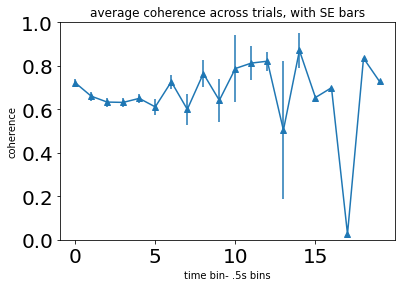

In [142]:
df2_SE = df.sem(axis=0,skipna=True)
plt.errorbar(df2.index, df2, df2_SE, marker='^')  
plt.ylim(0,1)
plt.title('average coherence across trials, with SE bars') 
plt.ylabel('coherence')
plt.xlabel('time bin- .5s bins') 

In [90]:
df2.index 

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [97]:
df2_SE

0    0.055230
1    0.072263
2    0.083004
3    0.085734
4    0.070174
5    0.103515
6    0.098312
7    0.052762
8         NaN
9         NaN
dtype: float64

In [ ]:
#I think what i want first is only the run period. SO maybe my first priority should be the speed threshold the trial times too. 


Text(0.5, 0, 'time bin- .5s bins')

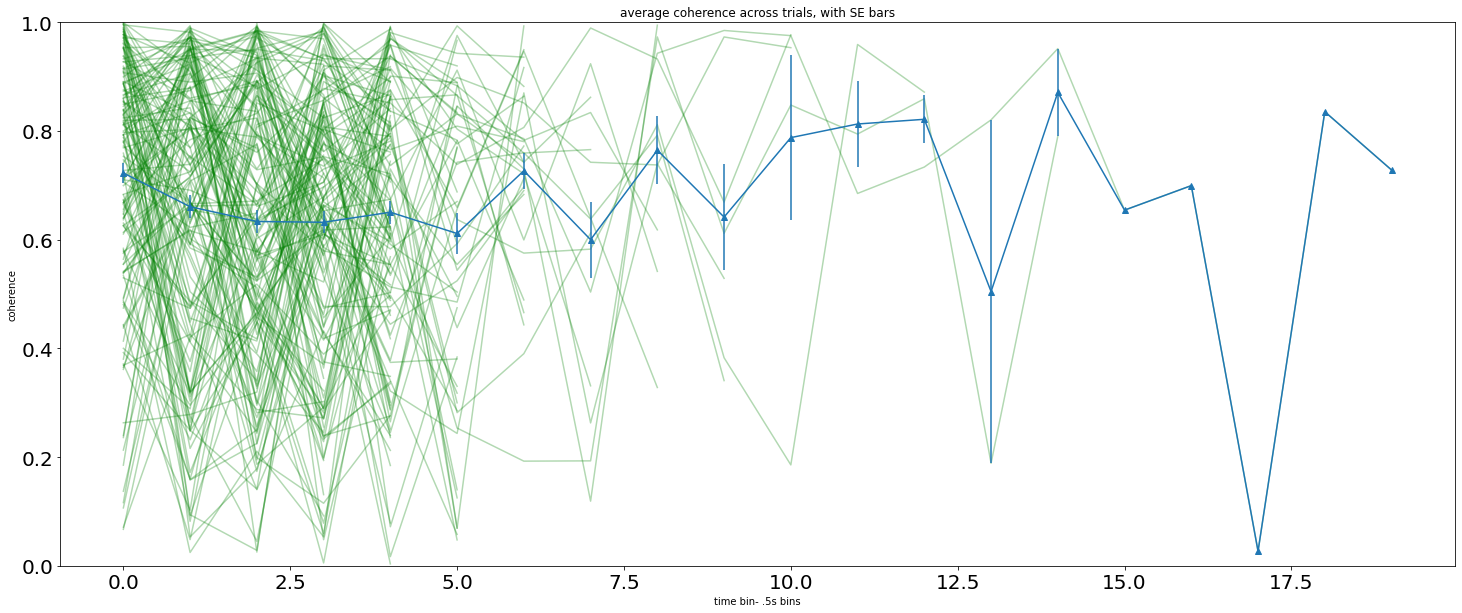

In [143]:
%matplotlib inline
plt.figure(figsize=(25,10))
saved_times = []
saved_data = []
for times in range(len(trial_times)):
    trial_start=trial_times[times][0]
    trial_end = trial_times[times][1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed=[]
#first, mask the data. 
#Then for every time in the masked times data, subtract the first time of that trial so that they all start at zero. 
    for ix in range(len(masked_time)):
        masked_times_zeroed.append(masked_time[ix]- trial_times[times][0])
    saved_times.append(masked_times_zeroed)
    saved_data.append(masked_data)
saved_data_lists=[]
for ix in range(len(saved_data)): 
    saved_data_lists.append(saved_data[ix].tolist())
df = pd.DataFrame(saved_data_lists)

for ix in range(len(df)):
    plt.plot(df.iloc[ix], color='g', alpha=.3)

    # plt.plot(masked_times_zeroed,masked_data, label = f'trial {times+1}')
    # plt.vlines(trial_start,0,1,color='g',label='trial_start',alpha=.6)
    # plt.vlines(trial_end,0,1,color='red',label='trial_end',alpha=.6)
# plt.title(')
plt.title(f'coherence over trials, aligned to start of trial\ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz \n only non-stem-switch trials- less than 4 seconds')


plt.ylabel('coherence')
plt.xlabel('time bins since start of trial- =second*2')
# plt.legend()


df2_SE = df.sem(axis=0,skipna=True)
plt.errorbar(df2.index, df2, df2_SE, marker='^')  
plt.ylim(0,1)
plt.title('average coherence across trials, with SE bars') 
plt.ylabel('coherence')
plt.xlabel('time bin- .5s bins') 

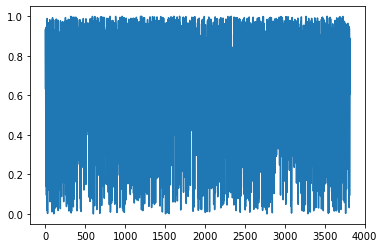

In [138]:
plt.plot(coh_seg[0])

In [264]:
df

,0,1,2,3,4,5
0,0.490915,0.679006,0.865843,0.716587,NaN,NaN
1,0.613483,0.179326,0.063175,0.040031,0.755834,NaN
2,0.448985,0.514331,0.314356,0.827844,0.702248,NaN
3,0.936471,0.881989,0.967826,0.350551,NaN,NaN
4,0.229012,0.233531,0.826678,0.218914,0.560056,NaN
...,...,...,...,...,...,...
118,0.308191,0.984987,0.291594,0.270223,0.136027,NaN
119,NaN,NaN,NaN,NaN,NaN,NaN
120,NaN,NaN,NaN,NaN,NaN,NaN
121,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#how can i investaigate the sawtoothyness? does it look that way on the heatmap? 

In [ ]:
freq_seg = c.frequencies[(c.frequencies >= 7.5) & (c.frequencies <=10)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies >= 7.5) & (c.frequencies <=10)]

frequency resolution: 6.0


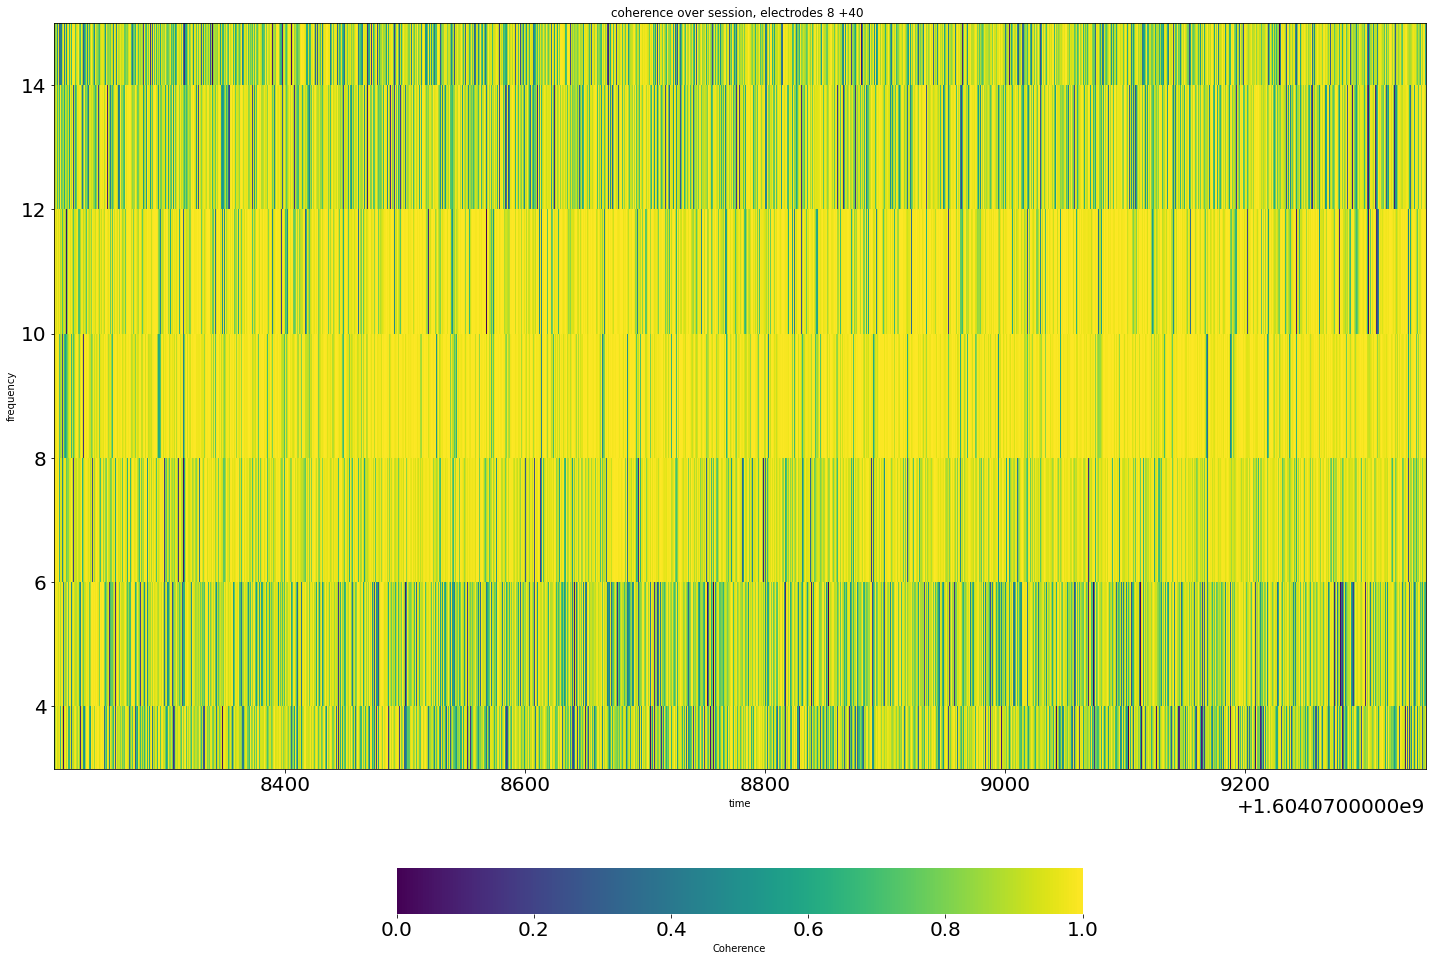

In [144]:
#first thing i want to do is get the heat map for the coherence at 8hz to make sure the line plots agree 

%matplotlib inline
time_halfbandwidth_product = 1.5
sampling_frequency = 1000
time_res=.5


electrode_ix1= 0
electrode_ix2= 2


time_data = x_elect_lfp[electrode_ix1]
signal = np.zeros((len(time_data), 2))
signal[:,0] = y_elect_lfp[electrode_ix1]
signal[:,1]=y_elect_lfp[electrode_ix2]



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=time_res,
               time_window_step=None,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
freq_seg = c.frequencies[(c.frequencies >= 7.5) & (c.frequencies <=9)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies >= 7.5) & (c.frequencies <=9)]
freq_seg

time_grid, freq_grid = np.meshgrid(
    np.append(c.time, c.time[-1]),
    np.append(c.frequencies, m.nyquist_frequency))

plt.figure(figsize=(20,15))
mesh = plt.pcolormesh(time_grid,freq_grid , c.coherence_magnitude()[..., 0, 1].squeeze().T,
                             vmin=0.0, vmax=1.0, cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.ylim(3,15)
plt.title(f'coherence over session, electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} ')


plt.tight_layout()
cb = plt.colorbar(mesh, orientation='horizontal',
                  shrink=.5, aspect=15, pad=0.1, label='Coherence')
# cb = plt.colorbar(mesh, ax.ravel().tolist(), orientation='horizontal',
#                   shrink=.5, aspect=15, pad=0.1, label='Coherence')
cb.outline.set_linewidth(0)
cb.outline.set_linewidth(0)
print('frequency resolution: {}'.format(m.frequency_resolution))


In [150]:
freq_seg = c.frequencies[(c.frequencies >= 7.5) & (c.frequencies <=9)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies >= 7.5) & (c.frequencies <=9)]
freq_seg

array([8.])

In [ ]:
#first of all, i should plot the coherence over a trial with the 
#lfp from that trial to see if i generally agree with the coherence. 

In [146]:
trial= 110
trial_times_single = trial_times[trial]
trial_times_single

[1604079037.374853, 1604079039.712853]

In [147]:
x_elect_lfp, y_elect_lfp = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, lfp_eseries, lfp_timestamps, lfp_data)


x_speed, y_speed = get_speed_timestamp(trial_times_single[0],trial_times_single[1], position_info)




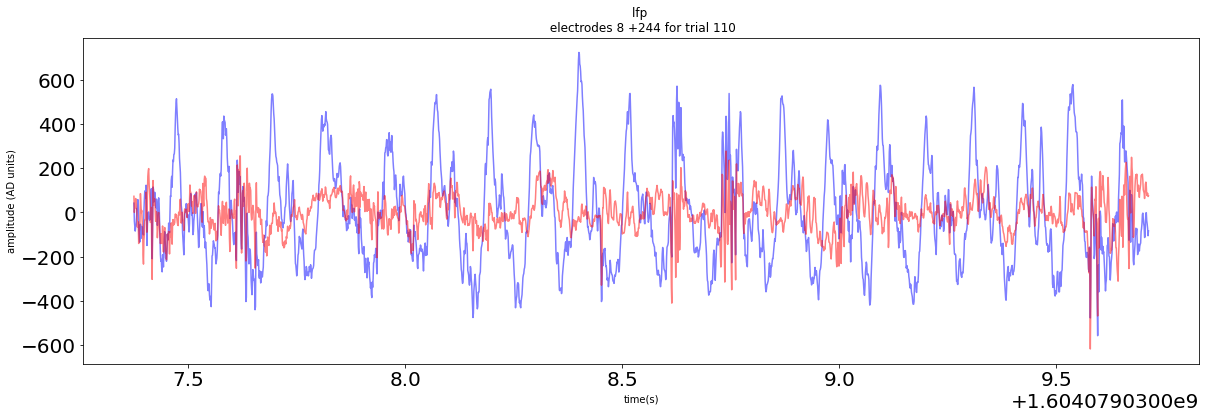

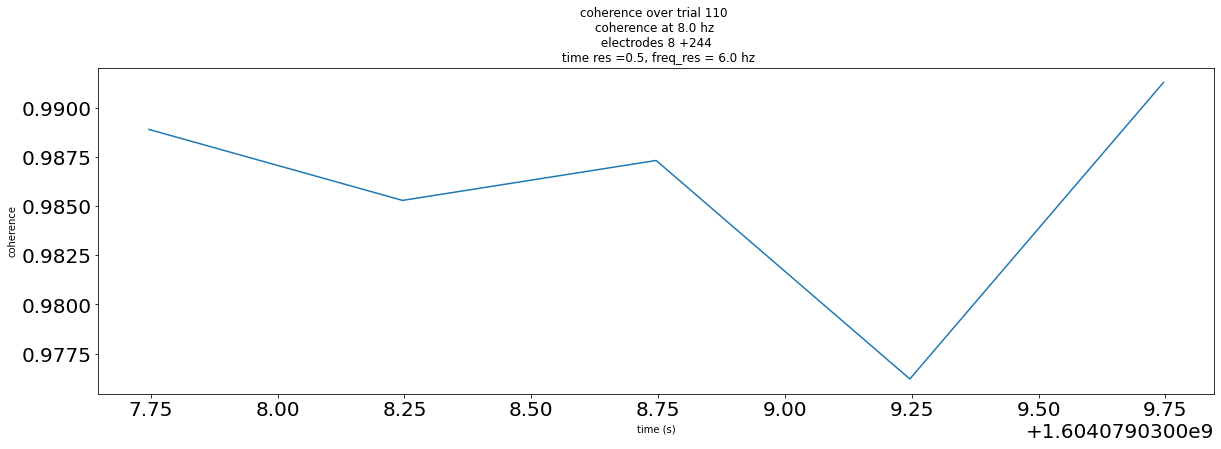

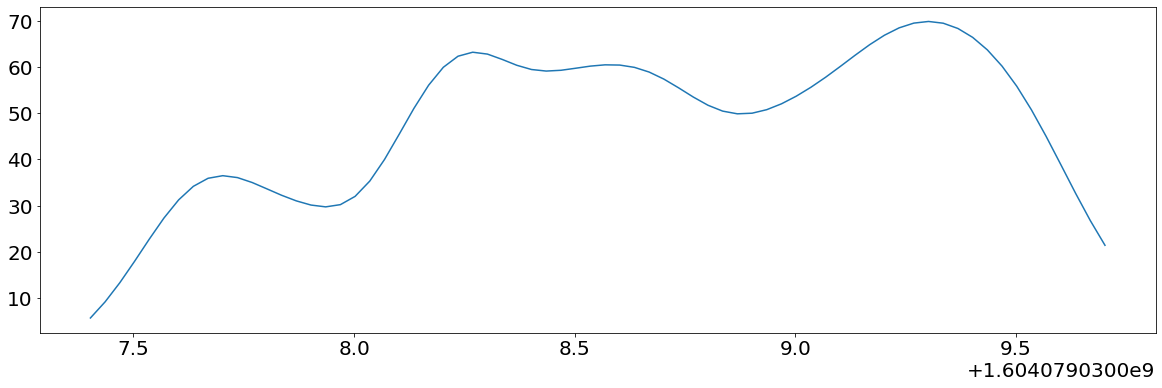

In [148]:
electrode_ix1= 0
electrode_ix2= 4

plt.figure(figsize=(20,6))
plt.plot(x_elect_lfp[electrode_ix1],y_elect_lfp[electrode_ix1], color='b', alpha=.5)
plt.plot(x_elect_lfp[electrode_ix2],y_elect_lfp[electrode_ix2], color='r', alpha=.5)
plt.title(f'lfp \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} for trial {trial}')
plt.xlabel('time(s)')
plt.ylabel('amplitude (AD units)')

plt.figure(figsize=(20,6))
saved_times = []
saved_data = []
for times in range(len(trial_times_single)):
    trial_start=trial_times_single[0]
    trial_end = trial_times_single[1]+.5
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed=[]
plt.plot(masked_time,masked_data)

plt.title(f'coherence over trial {trial} \ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz')
plt.ylabel('coherence')
plt.xlabel('time (s)')

plt.figure(figsize=(20,6))
plt.plot(x_speed, y_speed)
# plt.title('



In [67]:
# i should figure out how the time window is calculated somehow. is c.time the first of the .5 seconds? the middle? the end? 
#maybe thats a little much for me. 
theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])



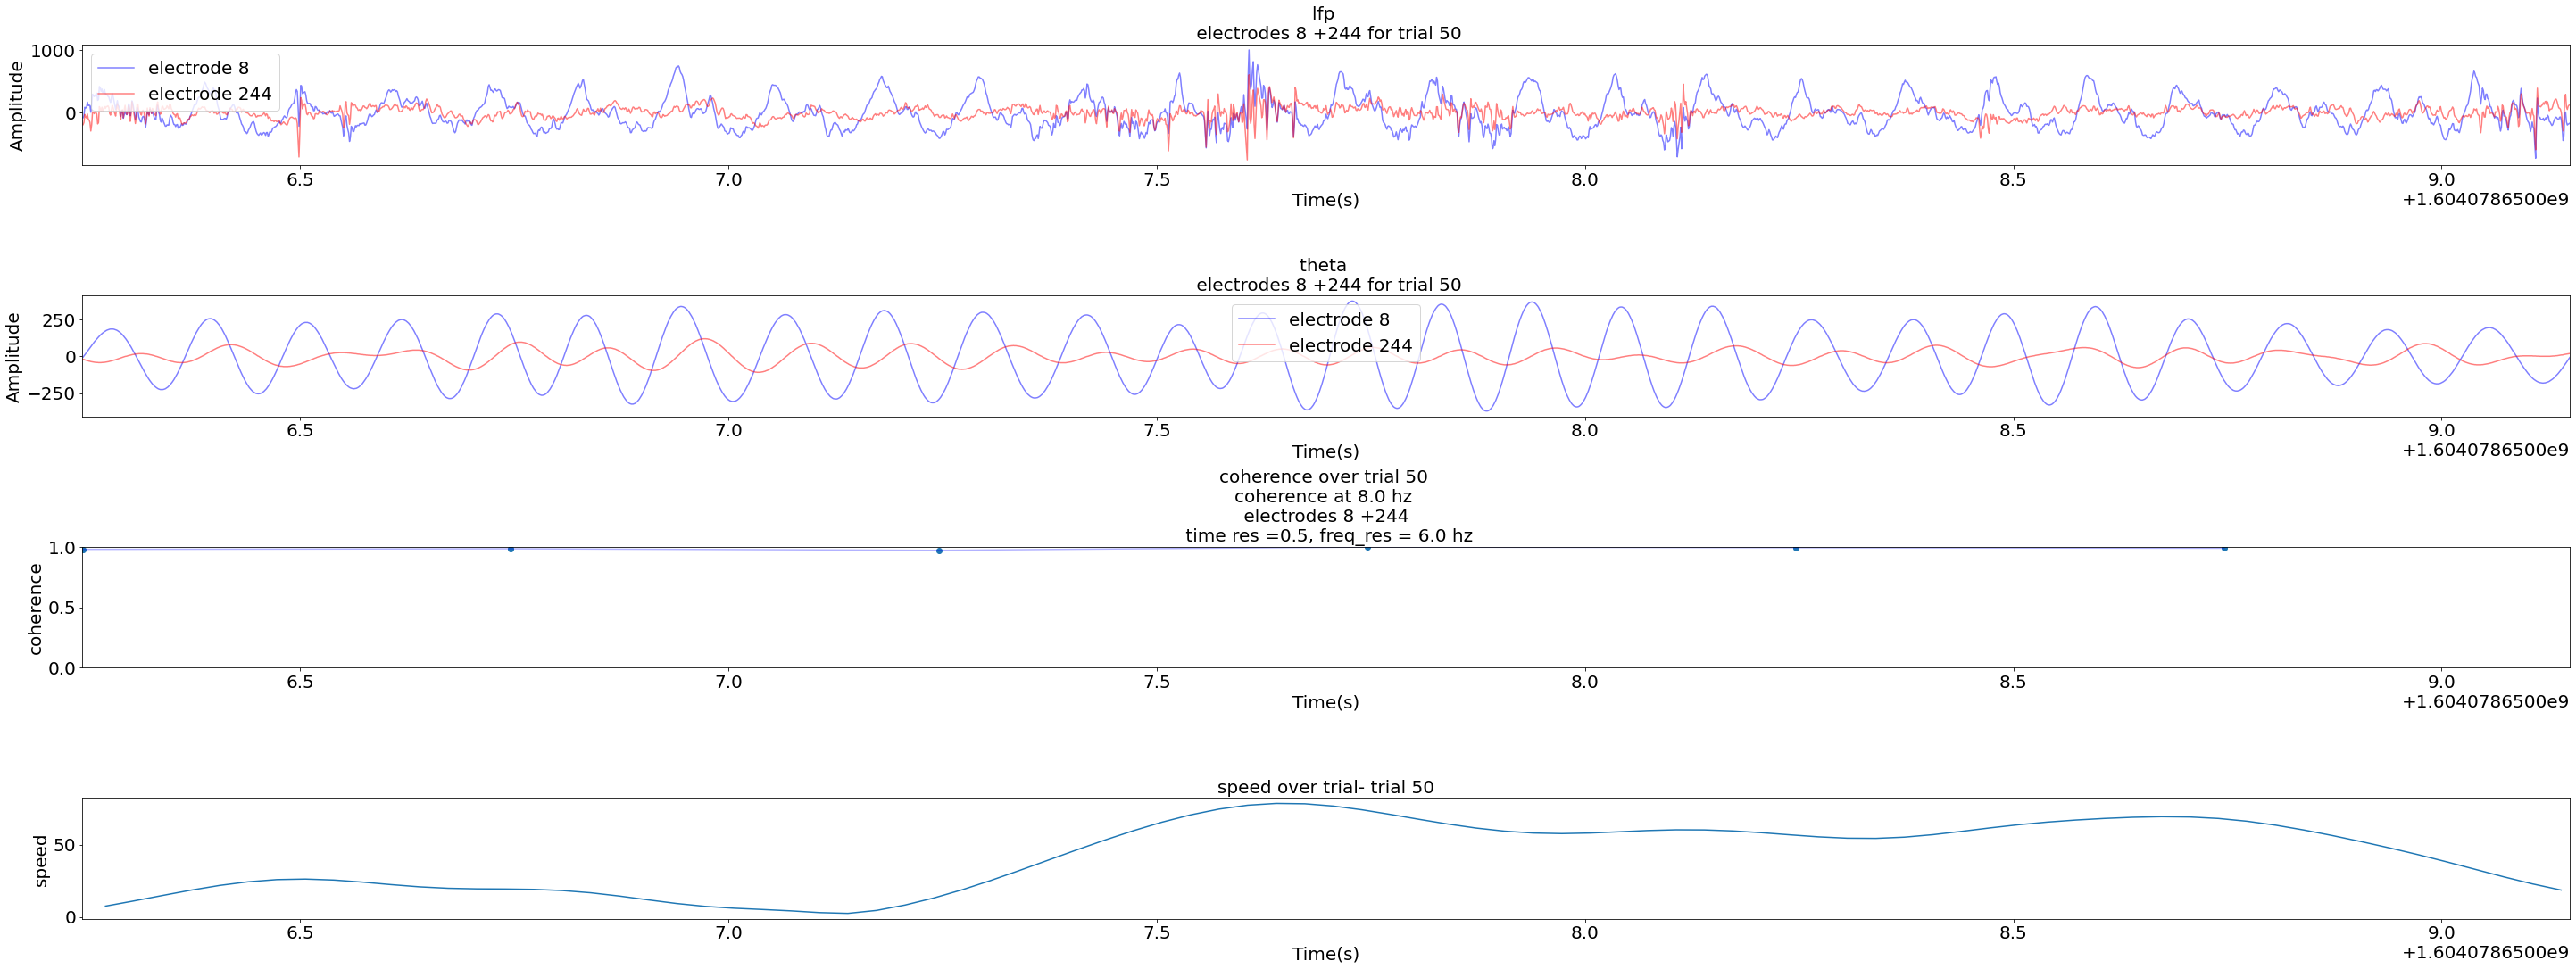

In [150]:
#want to make a subplot out of this. 
trial= 50
trial_times_single = trial_times[trial]
trial_times_single

x_elect_lfp, y_elect_lfp = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_theta, y_elect_theta = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, theta_eseries, theta_timestamps, theta_data)
x_speed, y_speed = get_speed_timestamp(trial_times_single[0],trial_times_single[1], position_info)

electrode_ix1= 0
electrode_ix2= 4
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(40,15))
axes[0].plot(x_elect_lfp[electrode_ix1],y_elect_lfp[electrode_ix1], color='b', alpha=.5, label = f'electrode {electrode_id[electrode_ix1]}')
axes[0].plot(x_elect_lfp[electrode_ix2],y_elect_lfp[electrode_ix2], color='r', alpha=.5, label = f'electrode {electrode_id[electrode_ix2]}')
axes[0].set_xlabel('Time(s)',fontsize=20)
axes[0].set_ylabel('Amplitude',fontsize=20)
axes[0].set_title(f'lfp \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} for trial {trial}',fontsize=20)
axes[0].set_xlim(trial_times_single)
axes[0].legend(fontsize=20)



axes[1].plot(x_elect_theta[electrode_ix1],y_elect_theta[electrode_ix1], color='b', alpha=.5, label = f'electrode {electrode_id[electrode_ix1]}')
axes[1].plot(x_elect_theta[electrode_ix2],y_elect_theta[electrode_ix2], color='r', alpha=.5, label = f'electrode {electrode_id[electrode_ix2]}')
axes[1].set_xlabel('Time(s)',fontsize=20)
axes[1].set_ylabel('Amplitude',fontsize=20)
axes[1].set_title(f'theta \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} for trial {trial}',fontsize=20)
axes[1].set_xlim(trial_times_single)
axes[1].legend(fontsize=20)



saved_times = []
saved_data = []
for times in range(len(trial_times_single)):
    trial_start=trial_times_single[0]
    trial_end = trial_times_single[1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed=[]

axes[2].scatter(masked_time,masked_data)
axes[2].plot(masked_time,masked_data, color='b',alpha=.3)
axes[2].set_xlabel('Time(s)',fontsize=20)
axes[2].set_ylabel('coherence',fontsize=20)
axes[2].set_title(f'coherence over trial {trial} \ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz',fontsize=20)
axes[2].set_xlim(trial_times_single)
axes[2].set_ylim(0,1)




axes[3].plot(x_speed, y_speed)
axes[3].set_xlabel('Time(s)',fontsize=20)
axes[3].set_ylabel('speed',fontsize=20)
axes[3].set_title(f'speed over trial- trial {trial}',fontsize=20)
axes[3].set_xlim(trial_times_single)





fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)





Text(0, 0.5, 'coherence')

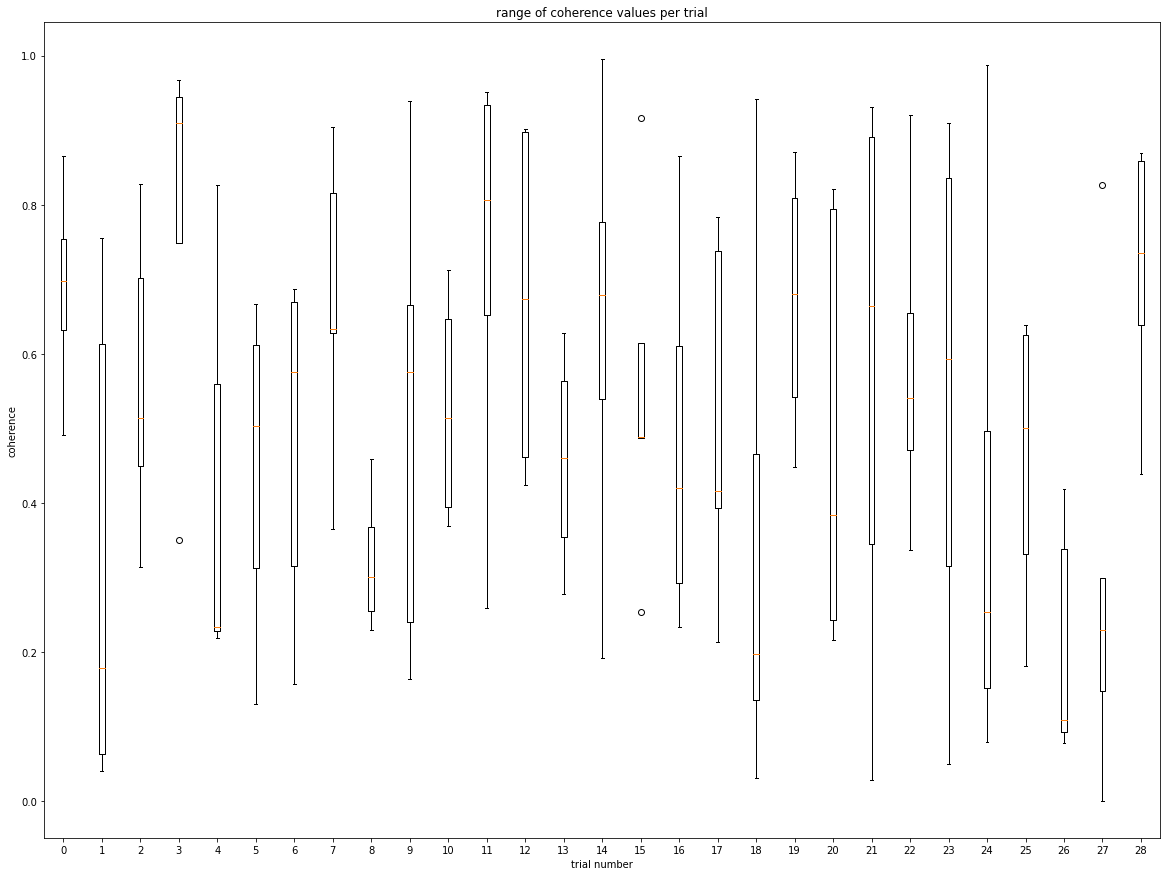

In [282]:
plt.figure(figsize=(20,15))
for ix in range(int((len(df)-5)/4)):
    trial1 = np.array(df.iloc[ix])
    trial1 = trial1[~np.isnan(trial1)]
    plt.boxplot(trial1,positions=[ix])
    
plt.title('range of coherence values per trial')
plt.xlabel('trial number')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

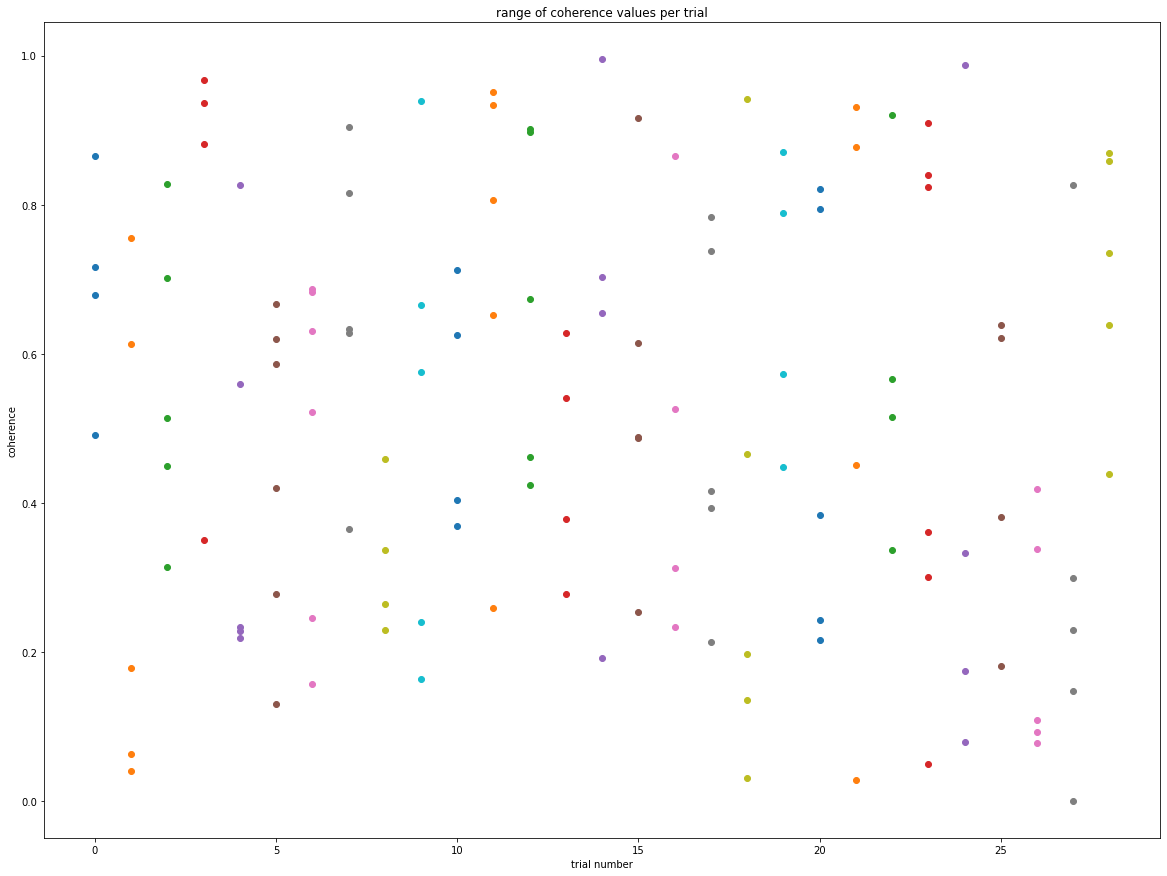

In [284]:
plt.figure(figsize=(20,15))
for ix in range(int((len(df)-5)/4)):
    trial1 = np.array(df.iloc[ix])
    trial1 = trial1[~np.isnan(trial1)]
    plt.scatter(ix*np.ones(len(trial1)),trial1)
    # plt.boxplot(trial1,positions=[ix])
    
plt.title('range of coherence values per trial')
plt.xlabel('trial number')
plt.ylabel('coherence')

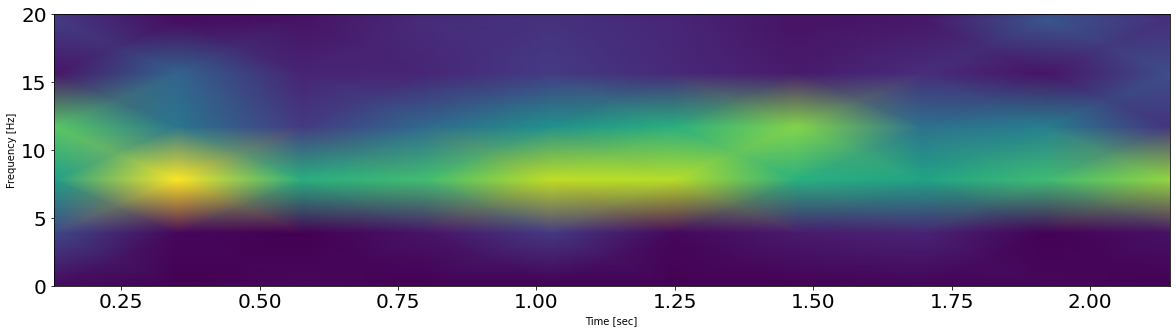

In [36]:
from spyglass.common.signal_processing import hilbert_decomp
from scipy import signal as sig
ix=0
plt.figure(figsize=(20,5))
f, t, Sxx = sig.spectrogram(y_elect_lfp[ix], 1000)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,20)
plt.show()


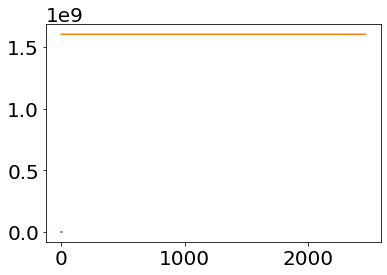

In [37]:
plt.plot(t)
plt.plot(x_elect_lfp[ix])

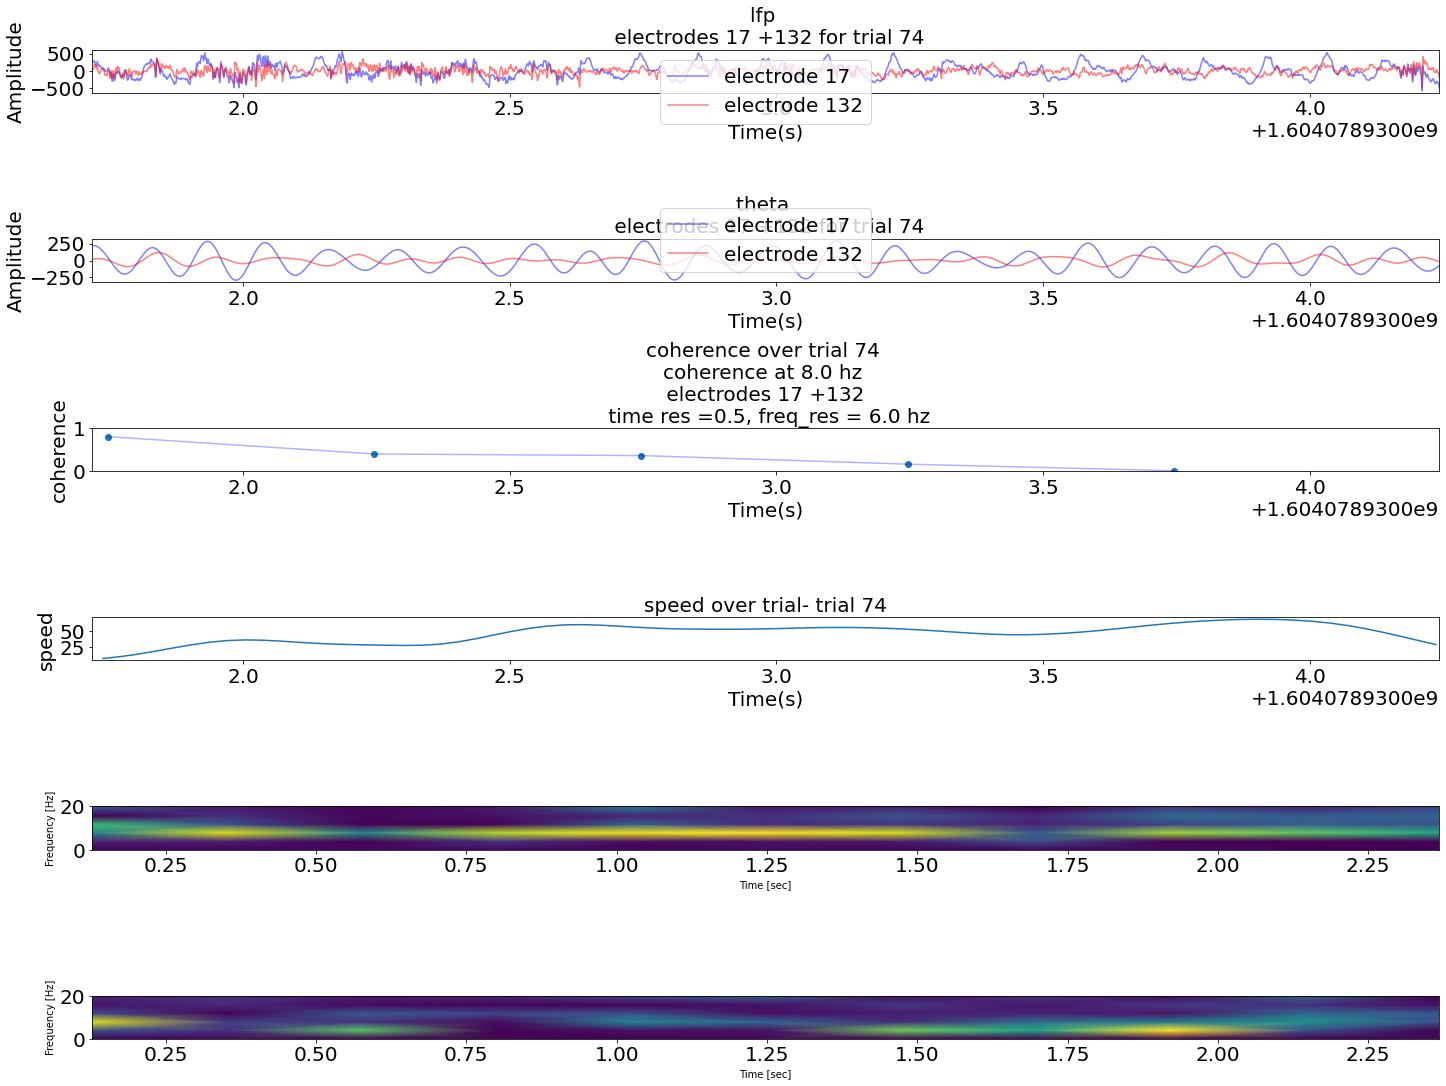

In [300]:
#want to make a subplot out of this. 
trial= 74


trial_times_single = trial_times[trial]
trial_times_single

x_elect_lfp, y_elect_lfp = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_theta, y_elect_theta = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, theta_eseries, theta_timestamps, theta_data)
x_speed, y_speed = get_speed_timestamp(trial_times_single[0],trial_times_single[1], position_info)

electrode_ix1= 0
electrode_ix2= 2

import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(20,15))
axes[0].plot(x_elect_lfp[electrode_ix1],y_elect_lfp[electrode_ix1], color='b', alpha=.5, label = f'electrode {electrode_id[electrode_ix1]}')
axes[0].plot(x_elect_lfp[electrode_ix2],y_elect_lfp[electrode_ix2], color='r', alpha=.5, label = f'electrode {electrode_id[electrode_ix2]}')
axes[0].set_xlabel('Time(s)',fontsize=20)
axes[0].set_ylabel('Amplitude',fontsize=20)
axes[0].set_title(f'lfp \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} for trial {trial}',fontsize=20)
axes[0].set_xlim(trial_times_single)
axes[0].legend(fontsize=20)



axes[1].plot(x_elect_theta[electrode_ix1],y_elect_theta[electrode_ix1], color='b', alpha=.5, label = f'electrode {electrode_id[electrode_ix1]}')
axes[1].plot(x_elect_theta[electrode_ix2],y_elect_theta[electrode_ix2], color='r', alpha=.5, label = f'electrode {electrode_id[electrode_ix2]}')
axes[1].set_xlabel('Time(s)',fontsize=20)
axes[1].set_ylabel('Amplitude',fontsize=20)
axes[1].set_title(f'theta \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} for trial {trial}',fontsize=20)
axes[1].set_xlim(trial_times_single)
axes[1].legend(fontsize=20)



saved_times = []
saved_data = []
for times in range(len(trial_times_single)):
    trial_start=trial_times_single[0]
    trial_end = trial_times_single[1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed=[]

axes[2].scatter(masked_time,masked_data)
axes[2].plot(masked_time,masked_data, color='b',alpha=.3)
axes[2].set_xlabel('Time(s)',fontsize=20)
axes[2].set_ylabel('coherence',fontsize=20)
axes[2].set_title(f'coherence over trial {trial} \ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz',fontsize=20)
axes[2].set_xlim(trial_times_single)
axes[2].set_ylim(0,1)




axes[3].plot(x_speed, y_speed)
axes[3].set_xlabel('Time(s)',fontsize=20)
axes[3].set_ylabel('speed',fontsize=20)
axes[3].set_title(f'speed over trial- trial {trial}',fontsize=20)
axes[3].set_xlim(trial_times_single)





f1, t1,Sxx1 = sig.spectrogram(y_elect_lfp[electrode_ix1], 1000)
axes[4].pcolormesh(t1, f1, Sxx1, shading='gouraud')
axes[4].set_ylabel('Frequency [Hz]')
axes[4].set_xlabel('Time [sec]')
axes[4].set_ylim(0,20)
# axes[4].set_xlim(trial_times_single)


f2, t2,Sxx2 = sig.spectrogram(y_elect_lfp[electrode_ix2], 1000)
axes[5].pcolormesh(t2, f2, Sxx2, shading='gouraud')
axes[5].set_ylabel('Frequency [Hz]')
axes[5].set_xlabel('Time [sec]')
axes[5].set_ylim(0,20)
# axes[5].set_xlim(trial_times_single)


fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)





In [42]:
c.time


array([1.60407821e+09, 1.60407821e+09, 1.60407821e+09, ...,
       1.60407935e+09, 1.60407935e+09, 1.60407935e+09])

5.6


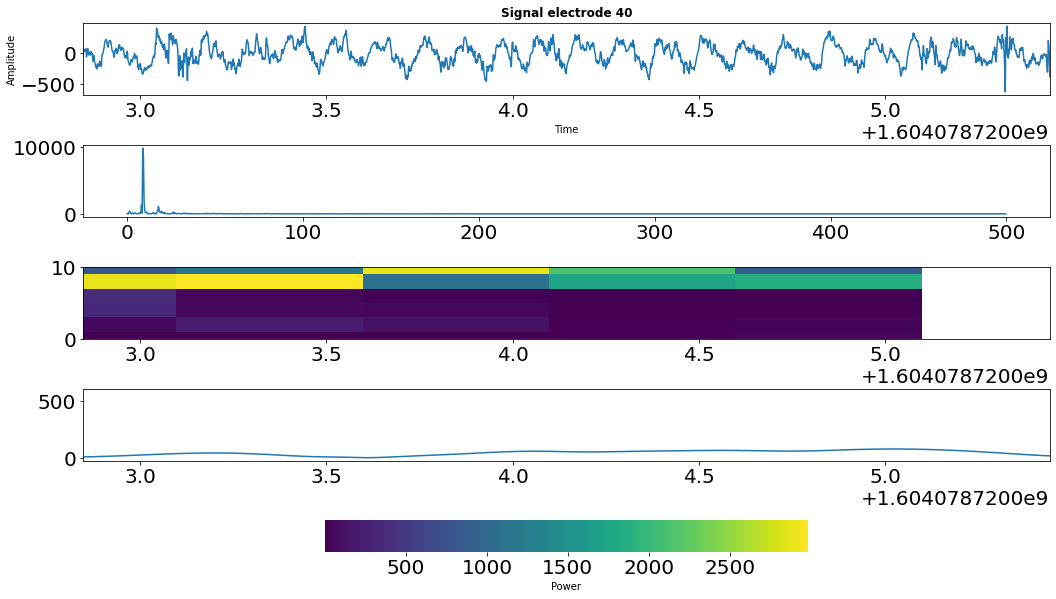

In [86]:
# frequency_of_interest = [200, 50]
electrode_ix1= 1

sampling_frequency = 1000
time_halfbandwidth_product = 1.4

time_data = x_elect_lfp[electrode_ix1]
signal = y_elect_lfp[electrode_ix1]
noise = np.zeros(len(x_elect_lfp[electrode_ix1]))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 9))
axes[0].plot(time_data, signal)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Signal electrode {electrode_id[electrode_ix1]}', fontweight='bold')
axes[0].set_xlim(time_data[0], time_data[-1])



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               # time_window_duration=.5,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies)
axes[1].plot(c.frequencies, c.power().squeeze())


m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=.5,
               time_window_step=None,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
mesh = axes[2].pcolormesh(c.time, c.frequencies, c.power().squeeze().T,
                            cmap='viridis')
axes[2].set_ylim((0, 10))
axes[2].set_xlim(time_data[0], time_data[-1])



plt.tight_layout()

cb = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation='horizontal',
                  shrink=.5, aspect=15, pad=0.1, label='Power')
cb.outline.set_linewidth(0)

axes[3].plot(x_pos,y_pos)
axes[3].set_xlim(time_data[0], time_data[-1])


print(m.frequency_resolution)

#cut off color spectrum thing at 600 or something to see smaller differences 

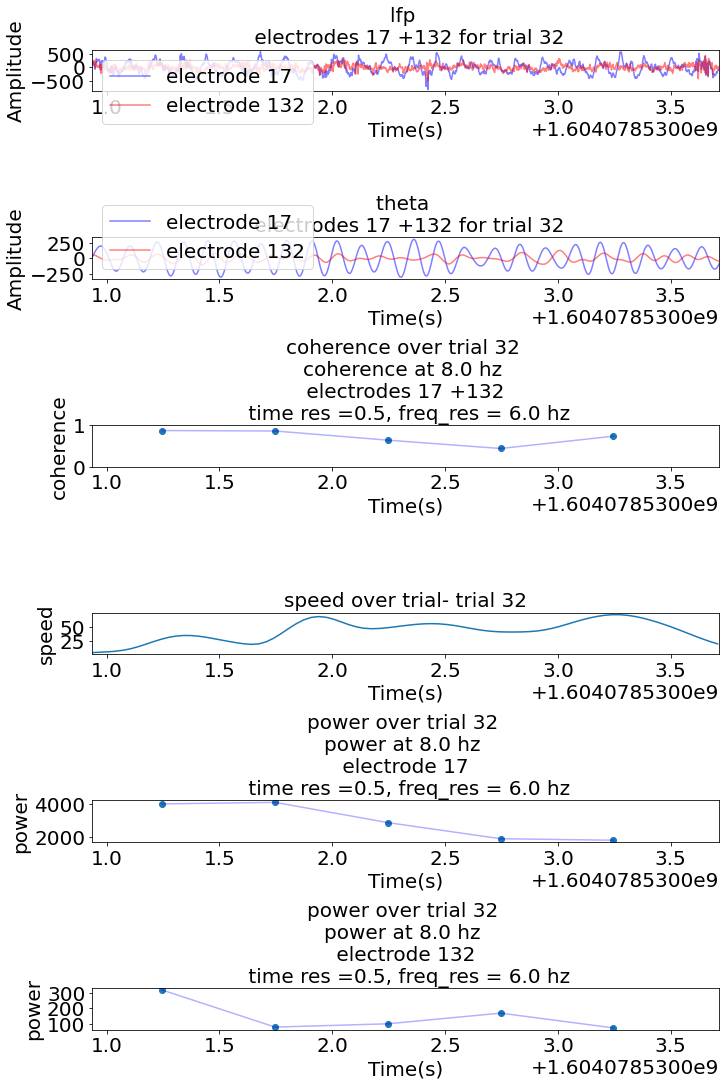

In [79]:
#want to make a subplot out of this. 
trial= 32


trial_times_single = trial_times[trial]
trial_times_single

x_elect_lfp, y_elect_lfp = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_theta, y_elect_theta = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, theta_eseries, theta_timestamps, theta_data)
x_speed, y_speed = get_speed_timestamp(trial_times_single[0],trial_times_single[1], position_info)

electrode_ix1= 0
electrode_ix2= 2

time_data = x_elect_lfp[electrode_ix1]
signal = y_elect_lfp[electrode_ix1]
noise = np.zeros(len(x_elect_lfp[electrode_ix1]))

import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,15))
axes[0].plot(x_elect_lfp[electrode_ix1],y_elect_lfp[electrode_ix1], color='b', alpha=.5, label = f'electrode {electrode_id[electrode_ix1]}')
axes[0].plot(x_elect_lfp[electrode_ix2],y_elect_lfp[electrode_ix2], color='r', alpha=.5, label = f'electrode {electrode_id[electrode_ix2]}')
axes[0].set_xlabel('Time(s)',fontsize=20)
axes[0].set_ylabel('Amplitude',fontsize=20)
axes[0].set_title(f'lfp \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} for trial {trial}',fontsize=20)
axes[0].set_xlim(trial_times_single)
axes[0].legend(fontsize=20)



axes[1].plot(x_elect_theta[electrode_ix1],y_elect_theta[electrode_ix1], color='b', alpha=.5, label = f'electrode {electrode_id[electrode_ix1]}')
axes[1].plot(x_elect_theta[electrode_ix2],y_elect_theta[electrode_ix2], color='r', alpha=.5, label = f'electrode {electrode_id[electrode_ix2]}')
axes[1].set_xlabel('Time(s)',fontsize=20)
axes[1].set_ylabel('Amplitude',fontsize=20)
axes[1].set_title(f'theta \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} for trial {trial}',fontsize=20)
axes[1].set_xlim(trial_times_single)
axes[1].legend(fontsize=20)



# saved_times = []
# saved_data = []

for times in range(len(trial_times_single)):
    trial_start=trial_times_single[0]
    trial_end = trial_times_single[1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data_coh = coh_seg[0][ind_start&ind_end]
    masked_data_power_1 = power_seg_1[0][ind_start&ind_end]
    masked_data_power_2 = power_seg_2[0][ind_start&ind_end]


    masked_times_zeroed=[]

axes[2].scatter(masked_time,masked_data_coh)
axes[2].plot(masked_time,masked_data_coh, color='b',alpha=.3)
axes[2].set_xlabel('Time(s)',fontsize=20)
axes[2].set_ylabel('coherence',fontsize=20)
axes[2].set_title(f'coherence over trial {trial} \ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz',fontsize=20)
axes[2].set_xlim(trial_times_single)
axes[2].set_ylim(0,1)




axes[3].plot(x_speed, y_speed)
axes[3].set_xlabel('Time(s)',fontsize=20)
axes[3].set_ylabel('speed',fontsize=20)
axes[3].set_title(f'speed over trial- trial {trial}',fontsize=20)
axes[3].set_xlim(trial_times_single)

axes[4].scatter(masked_time,masked_data_power_1)
axes[4].plot(masked_time,masked_data_power_1, color='b',alpha=.3)
axes[4].set_xlabel('Time(s)',fontsize=20)
axes[4].set_ylabel('power',fontsize=20)
axes[4].set_title(f'power over trial {trial} \npower at {freq_seg[0]} hz \n electrode {electrode_id[electrode_ix1]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz',fontsize=20)
axes[4].set_xlim(trial_times_single)
# axes[4].set_ylim(0,1)


axes[5].scatter(masked_time,masked_data_power_2)
axes[5].plot(masked_time,masked_data_power_2, color='b',alpha=.3)
axes[5].set_xlabel('Time(s)',fontsize=20)
axes[5].set_ylabel('power',fontsize=20)
axes[5].set_title(f'power over trial {trial} \npower at {freq_seg[0]} hz \n electrode {electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz',fontsize=20)
axes[5].set_xlim(trial_times_single)


fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


[[coh1, coh2, coh3],[coh1, coh2, coh3]]

#expect 3 D, time trials, tapers?
#stack or concatinate 
#the same size chunk- take like 2 seconds. 
#make sure i have high theta power on two electrodes and then try 


In [69]:
trial_start

1604078827.9938529

In [57]:

%matplotlib inline
time_halfbandwidth_product = 1.5
sampling_frequency = 1000
time_res=.5


electrode_ix1= 0
electrode_ix2= 2


time_data = x_elect_lfp[electrode_ix1]
signal = np.zeros((len(time_data), 2))
signal[:,0] = y_elect_lfp[electrode_ix1]
signal[:,1]=y_elect_lfp[electrode_ix2]



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=time_res,
               time_window_step=None,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
freq_seg = c.frequencies[(c.frequencies >= 7.5) & (c.frequencies <=9)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies >= 7.5) & (c.frequencies <=9)]
power_seg_1 = c.power().squeeze().T[0][(c.frequencies >= 7.5) & (c.frequencies <=9)]
power_seg_2 = c.power().squeeze().T[1][(c.frequencies >= 7.5) & (c.frequencies <=9)]



freq_seg


array([8.])

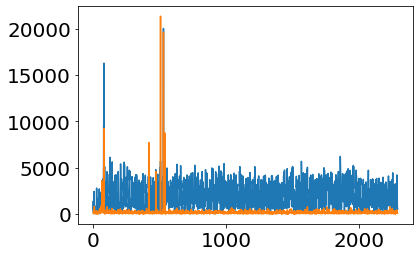

In [80]:
plt.plot(power_seg_1[0])
plt.plot(power_seg_2[0])

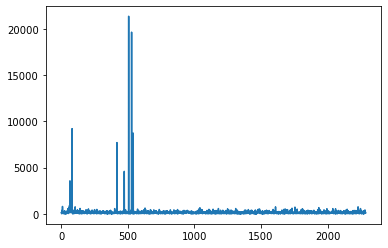

In [60]:
plt.plot(power_seg_2[0])

In [ ]:
trial= 60

for ix in range(0,trial):
    plt.figure()
    trial_times_single = trial_times[ix]
    trial_times_single

    x_elect_lfp, y_elect_lfp = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
    x_elect_theta, y_elect_theta = get_x_y_timestamp_list(trial_times_single[0],trial_times_single[1], electrode_id, theta_eseries, theta_timestamps, theta_data)
    x_speed, y_speed = get_speed_timestamp(trial_times_single[0],trial_times_single[1], position_info)

    electrode_ix1= 0
    electrode_ix2= 2

    time_data = x_elect_lfp[electrode_ix1]
    signal = y_elect_lfp[electrode_ix1]
    noise = np.zeros(len(x_elect_lfp[electrode_ix1]))


    for times in range(len(trial_times_single)):
        trial_start=trial_times_single[0]
        trial_end = trial_times_single[1]
        ind_start = c.time>=trial_start 
        ind_end = c.time<=trial_end
        masked_time = c.time[ind_start&ind_end]
        masked_data_coh = coh_seg[0][ind_start&ind_end]
        masked_data_power_1 = power_seg_1[0][ind_start&ind_end]
        masked_data_power_2 = power_seg_2[0][ind_start&ind_end]
    plt.plot(masked_data_power_1, label='power1')
    plt.plot(masked_data_power_2, label='power2')
    plt.plot(masked_data_coh*1000, label='coherence')
    plt.legend()







In [ ]:
# now what i want to do is get the lfp for the entire session for two electrodes. maybe look at all electrodes to make sure i have high theta power 

In [94]:
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])


position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()

electrode_id = [17,40,132,300]
time_from_start = 0 #in seconds
time_interval_s = num_secs_to_get
sampling_rate_lfp = 1000
epoch = (IntervalList & {'nwb_file_name':nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)




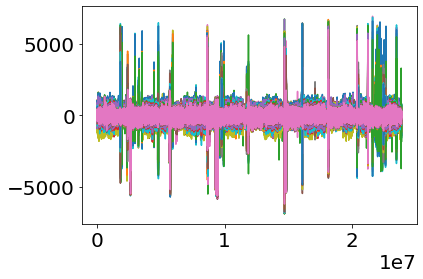

In [107]:
plt.plot(lfp_data[:])

(97,)